In [13]:
# !pip install xlrd
# !pip install openpyxl 
# !pip install awswrangler

In [9]:
import pandas as pd
import boto3
import awswrangler as wr

temp_df = pd.DataFrame()
df = pd.concat([wr.s3.read_excel('s3://ygone-test/data/11.18 수요예측 검토(와이지-원).xlsx', sheet_name = '국내세부(data)'),
                wr.s3.read_excel('s3://ygone-test/data/11.18 수요예측 검토(와이지-원).xlsx', sheet_name = '해외세부(data)')])
df['수주일'] = pd.to_datetime(df['수주일'])
temp_df[['item_id', 'timestamp', 'demand']] = df[['제품', '수주일', '수주수량']]
temp_df = pd.DataFrame(temp_df.groupby(['item_id', 'timestamp'])['demand'].sum()).reset_index()

wr.s3.to_csv(
    df= temp_df,
    path= 's3://ygone-test/data/daily_df.csv',
    index = False
)
wr.s3.to_csv(
    df= temp_df[temp_df['timestamp'] <'2022-01-01'],
    path= 's3://ygone-test/data/import_domestic_daily_2021.csv',
    index = False
)

daily_df = temp_df.copy()

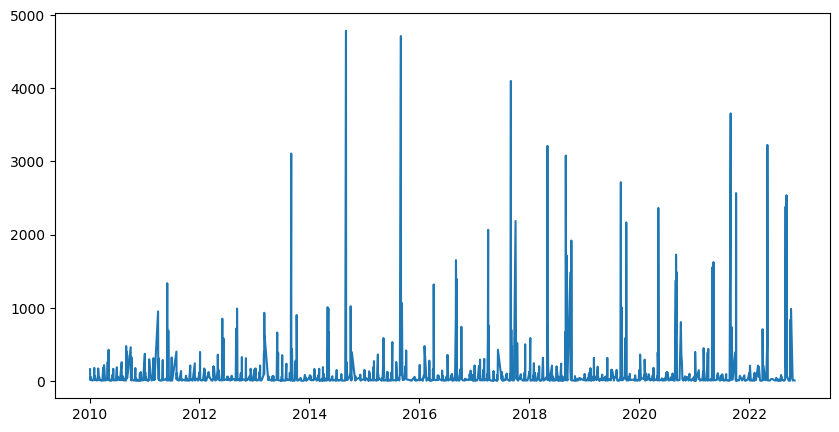

In [55]:
import matplotlib.pyplot as plt

temp_2 = daily_df[daily_df['item_id'] == 'SEM811040'].sort_values('timestamp')
plt.figure(figsize = (10,5))
plt.plot(temp_2['timestamp'], temp_2['demand'])
plt.show()

In [28]:
temp = pd.DataFrame(df.groupby(['제품','수주년도','월'])['수주수량'].sum()).reset_index()
temp['수주년도'] = temp['수주년도'].astype('str')
temp['월'] = temp['월'].astype('str')
temp['timestamp'] = temp['수주년도'] + '-' +temp['월'] + '-01'
temp['timestamp'] = pd.to_datetime(temp['timestamp'])
temp_df[['item_id', 'timestamp', 'demand']] = temp[['제품', 'timestamp', '수주수량']].copy()

wr.s3.to_csv(
    df= temp_df,
    path= 's3://ygone-test/data/monthly_df.csv',
    index = False
)

wr.s3.to_csv(
    df= temp_df[temp_df['timestamp'] <'2022-01-01'],
    path= 's3://ygone-test/data/import_domestic_monthly_2021.csv',
    index = False
)

monthly = temp_df.copy()

## Forecast Test

In [31]:
import boto3

session = boto3.Session() 
region = session.region_name
forecast = session.client(service_name="forecast") 
forecast_query = session.client(service_name="forecastquery")
s3 = session.client(service_name="s3")

In [42]:
datagroup_arn = forecast.list_dataset_groups()['DatasetGroups'][2]['DatasetGroupArn']
datagroup_arn

forecast.create_predictor(
    PredictorName='ygone_daily_2021_CNNQR_horizon_30',
    AlgorithmArn='arn:aws:forecast:::algorithm/CNN-QR',
    ForecastHorizon=30, ## 몇일 치의 데이터를 볼 것인가
    InputDataConfig={
        'DatasetGroupArn': datagroup_arn,
        'SupplementaryFeatures': [{'Name': 'holiday', 'Value': 'KR'}],
    },
    FeaturizationConfig={
        'ForecastFrequency': 'D',
        'Featurizations': [
            {'AttributeName': 'demand'}
        ]
    }
)

{'PredictorArn': 'arn:aws:forecast:ap-northeast-2:257832939543:predictor/ygone_daily_2021_CNNQR_horizon_30',
 'ResponseMetadata': {'RequestId': '49bef626-5bdc-4446-a1c4-8254b0594411',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 30 Nov 2022 01:26:21 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'connection': 'keep-alive',
   'x-amzn-requestid': '49bef626-5bdc-4446-a1c4-8254b0594411'},
  'RetryAttempts': 0}}

In [39]:
datagroup_arn = forecast.list_dataset_groups()['DatasetGroups'][1]['DatasetGroupArn']
datagroup_arn

forecast.create_predictor(
    PredictorName='ygone_monthly_2021_CNNQR_horizon_48',
    AlgorithmArn='arn:aws:forecast:::algorithm/CNN-QR',
    ForecastHorizon=48, ## 몇개월치 데이터를 볼 것인가
    InputDataConfig={
        'DatasetGroupArn': datagroup_arn,
        'SupplementaryFeatures': [{'Name': 'holiday', 'Value': 'KR'}],
    },
    FeaturizationConfig={
        'ForecastFrequency': 'M',
        'Featurizations': [
            {'AttributeName': 'demand'}
        ]
    }
)

{'PredictorArn': 'arn:aws:forecast:ap-northeast-2:257832939543:predictor/ygone_monthly_2021_CNNQR_horizon_48',
 'ResponseMetadata': {'RequestId': 'df8502fc-5a61-4986-a216-79f46ba8d887',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 30 Nov 2022 01:25:31 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'df8502fc-5a61-4986-a216-79f46ba8d887'},
  'RetryAttempts': 0}}

## Results Check

In [110]:
import numpy as np
from datetime import datetime

results = pd.DataFrame()
for i in range(4): 
    results = pd.concat([results, wr.s3.read_csv(f's3://ygone-test/import_domestic_daily_2021_result_2022-11-29T08-12-22Z_part{i}.csv')])    
    
results['item_id'] = results['item_id'].str.upper()
results['date'] = pd.to_datetime(results['date'])
results['p10'] = np.where(results['p10'] <= 0, 0, results['p10'])
results['p50'] = np.where(results['p50'] <= 0, 0, results['p50'])
results['p90'] = np.where(results['p90'] <= 0, 0, results['p90'])
results['month'] = results['date'].dt.month
temp_results = pd.DataFrame(results.groupby(['item_id', 'month'])['p90'].sum()).reset_index()
temp_results[temp_results['item_id'] == 'E5D70060']

,item_id,month,p90
10,E5D70060,1,135.227802
11,E5D70060,12,158.528137


In [109]:
daily_df = daily_df[daily_df['timestamp'] >= '2022-01-01']
daily_df['month'] = daily_df['timestamp'].dt.month
temp = pd.DataFrame(daily_df.groupby(['item_id', 'month'])['demand'].sum()).reset_index()
temp[temp['item_id'] == 'E5D70060']

,item_id,month,demand
32,E5D70060,1,924
33,E5D70060,2,1133
34,E5D70060,3,1421
35,E5D70060,4,1991
36,E5D70060,5,9983
37,E5D70060,6,211
38,E5D70060,7,371
39,E5D70060,8,718
40,E5D70060,9,16527
41,E5D70060,10,4356


In [106]:
results = pd.DataFrame()
for i in range(4): 
    results = pd.concat([results, wr.s3.read_csv(f's3://ygone-test/import_domestic_monthly_2021_result_2022-11-29T08-11-56Z_part{i}.csv')])   

results['item_id'] = results['item_id'].str.upper()
results[results['item_id'] == 'T2829523']

,item_id,date,p10,p50,p90
0,T2829523,2022-01-01T00:00:00Z,0.431112,0.431112,15.944139
1,T2829523,2022-02-01T00:00:00Z,9.856445,38.369549,65.879303
2,T2829523,2022-03-01T00:00:00Z,-22.313131,-22.313131,0.050644
3,T2829523,2022-04-01T00:00:00Z,-7.287752,-7.287752,58.949287
4,T2829523,2022-05-01T00:00:00Z,-20.307013,5.314623,94.159431
5,T2829523,2022-06-01T00:00:00Z,-0.325861,-0.182426,55.342373
6,T2829523,2022-07-01T00:00:00Z,51.406536,51.406536,217.507156
7,T2829523,2022-08-01T00:00:00Z,-19.857927,-19.857927,76.669701
8,T2829523,2022-09-01T00:00:00Z,-9.590769,86.052040,205.939728
9,T2829523,2022-10-01T00:00:00Z,-22.055132,62.792709,181.801727
